# Use a Recurrent Neural Net to find Baby Names

I need a good name for a baby!  It should be unique, but not too weird.  Use an RNN to find some plausible baby names that have never been used.

First get some baby names from the social security administration:

In [2]:
!wget https://www.ssa.gov/oact/babynames/names.zip

wget: /home/jak/miniconda3/envs/deepRxn3/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /home/jak/miniconda3/envs/deepRxn3/lib/libssl.so.1.0.0: no version information available (required by wget)
wget: /home/jak/miniconda3/envs/deepRxn3/lib/libssl.so.1.0.0: no version information available (required by wget)
--2017-10-17 19:29:02--  https://www.ssa.gov/oact/babynames/names.zip
Resolving www.ssa.gov (www.ssa.gov)... 137.200.4.16, 2001:1930:e03::aaaa
Connecting to www.ssa.gov (www.ssa.gov)|137.200.4.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8207194 (7.8M) [application/zip]
Saving to: ‘names.zip.2’

names.zip.2         100%[===================>]   7.83M  2.21MB/s    in 3.6s    

2017-10-17 19:29:06 (2.16 MB/s) - ‘names.zip.2’ saved [8207194/8207194]



Next, extract the name info:

In [3]:
import zipfile
zip_ref = zipfile.ZipFile('./names.zip', 'r')
zip_ref.extractall('./names/')
zip_ref.close()

Load some libraries, print out the versions:

In [13]:
import glob, re
import matplotlib.pyplot as plt
import pandas as pd
import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
%matplotlib inline
%load_ext version_information
%version_information pandas, numpy, keras, matplotlib

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.1 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 6.1.0
OS Linux 4.4.0 97 generic x86_64 with debian stretch sid
pandas 0.20.1
numpy 1.11.3
keras 2.0.2
matplotlib 2.0.2
Tue Oct 17 19:32:16 2017 EDT

Read in the name files:

In [14]:
master = pd.DataFrame()
for f in glob.glob('./names/yob*.txt'):
    yr = int(re.findall('\\d+',f)[0])
    dat=pd.read_csv(f,names=['Name','Gender','Count'])
    dat['Year']=yr
    dat['Name']=dat['Name'].str.lower()
    dat['Fraction'] = dat.groupby('Gender',group_keys=False).apply(lambda f: f.Count/f.Count.sum())
    master=master.append(dat)

gender=master.groupby('Gender')
boys = gender.get_group('M').sort_values('Year')
girls = gender.get_group('F').sort_values('Year')

Next, inspect the data 

In [15]:
print(master.sample(20))


            Name Gender  Count  Year  Fraction
13927     jordan      M   8484  1988  0.004435
6888      devani      F     19  2007  0.000010
2990    mckynlee      F     57  2014  0.000032
9724        doak      M      9  1956  0.000004
6260     latitia      F     11  1985  0.000006
5593      rogene      F      7  1960  0.000003
3338        andi      F     15  1963  0.000008
8623      brooke      M     51  1961  0.000024
3614        sela      F     31  1996  0.000018
3819     stormie      F     13  1967  0.000008
8020   glorianna      F     15  2010  0.000008
8352       athel      M     10  1926  0.000009
1628      evette      F     39  1954  0.000020
9337     milinda      F      8  1989  0.000004
29870      salar      M      8  2009  0.000004
1344     kenneth      F     30  1916  0.000029
17957     edwing      M      6  1984  0.000003
18180    stepehn      M      6  1983  0.000003
28898    nicanor      M      8  2011  0.000004
18603   lauralyn      F      5  2010  0.000003


# Inspect some names over time

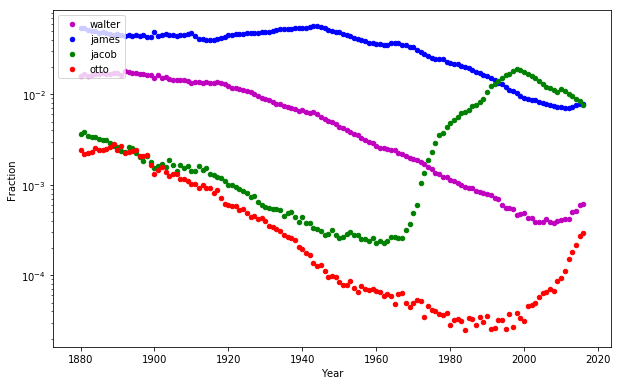

In [16]:
names=['walter','james','jacob','otto']
colors=['m','b','g','r']
plt.figure(figsize=(10,6.2))
ax=plt.gca()
for name,col in zip(names,colors):
    ax=boys[boys['Name']==name].plot('Year','Fraction',
                                     kind='scatter',logy=True,
                                     c=col,label=name,ax=ax)
plt.legend(loc='upper left')

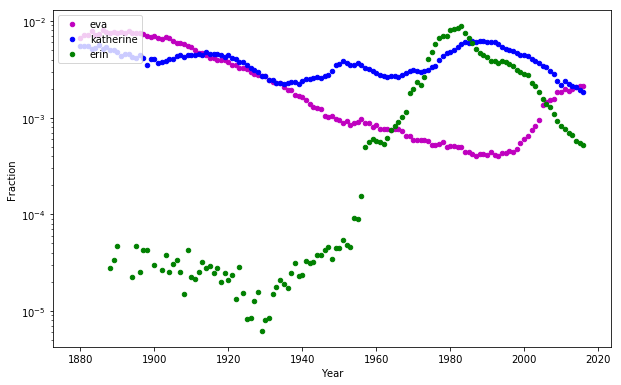

In [17]:
names=['eva','katherine','erin']
colors=['m','b','g','r']
plt.figure(figsize=(10,6.2))
ax=plt.gca()
for name,col in zip(names,colors):
    ax=girls[girls['Name']==name].plot('Year','Fraction',
                                     kind='scatter',logy=True,
                                     c=col,label=name,ax=ax)
plt.legend(loc='upper left')

Find names that are <0.05% but have been increasing recently and are short

In [66]:
namesnow = girls.loc[(girls.Fraction<1e-3)& (girls.Fraction>1e-4)&((girls.Year==2016) |(girls.Year==2013)) ,:]

name_piv = pd.pivot_table(namesnow,values='Fraction',index=['Name'],columns=['Year'])
name_piv['Delta']=(name_piv[2016]-name_piv[2013])/name_piv[2016]
promising = name_piv.Delta.nlargest(30)

print(promising.loc[promising.index.str.len()<7])


Name
thea      0.807795
freya     0.715218
remi      0.711081
aviana    0.648063
margot    0.637247
ariah     0.627236
saylor    0.611804
amina     0.591874
maisie    0.591520
lennon    0.577528
carter    0.570391
ariyah    0.565308
zelda     0.564787
river     0.564308
adley     0.541589
amara     0.538825
poppy     0.523006
jessa     0.517731
blake     0.506577
milani    0.495600
Name: Delta, dtype: float64


(array([  1.95310000e+04,   8.94860000e+04,   2.20394000e+05,
          5.75725000e+05,   1.43163000e+05,   5.27260000e+04,
          1.73980000e+04,   6.77000000e+02,   4.98000000e+02,
          2.26000000e+02]),
 array([  2. ,   3.3,   4.6,   5.9,   7.2,   8.5,   9.8,  11.1,  12.4,
         13.7,  15. ]),
 <a list of 10 Patch objects>)

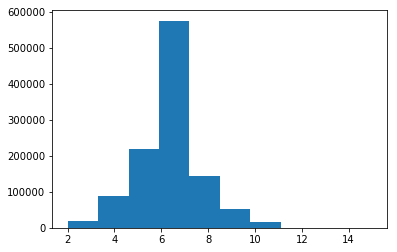

In [65]:
# average length
plt.hist(girls.Name.str.len())

For fun, how many girls names are palindromes?

In [68]:
def is_palindrome(s):
    return(str(s) == str(s)[::-1])

p=girls.Name.copy().map(is_palindrome).values
girls.loc[p,:].groupby(['Name']).agg('median').sort_values('Fraction',ascending=False).sample(10)

,Count,Year,Fraction
Name,,,
ardra,7.0,1970.5,0.000005
eme,6.5,2009.0,0.000004
abba,6.0,1924.0,0.000005
ava,156.0,1948.0,0.000155
aicia,5.5,1984.5,0.000003
ailia,5.0,2009.0,0.000003
lil,6.5,1957.5,0.000004
hayah,5.5,2010.0,0.000003
havah,6.0,2009.5,0.000003


# Train the Recurrent Neural Net

Ok, get to work: build RNN model for girl's names using the Keras text generation [example](https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py) as a starting point:

In [92]:
# blatant steal from : https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py
np.random.seed(8675309)

text = ' '.join(girls['Name'].values)
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 12
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# train the model, output generated text after each iteration
for iteration in range(1, 10):
    results=model.fit(X, y,
              batch_size=128,
              epochs=1,
              verbose=0)
    print('Iteration: {}, Loss: {:3.2f}'.format(iteration,results.history['loss'][0]))


corpus length: 8172527
total chars: 27
nb sequences: 2724172
Vectorization...
Build model...
Iteration: 1, Loss: 1.56
Iteration: 2, Loss: 1.48
Iteration: 3, Loss: 1.52
Iteration: 4, Loss: 1.54
Iteration: 5, Loss: 1.61
Iteration: 6, Loss: 1.58
Iteration: 7, Loss: 1.60
Iteration: 8, Loss: 1.60
Iteration: 9, Loss: 2.33


With the trained model, generate some predictions, then use `set` to find names that are not in the training set:

In [105]:
np.random.seed(8675309)
generated=''
diversity=0.5
sentence='sweet peanut'  # seed text to kick off predictions
for i in range(40000):
    x = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x[0, t, char_indices[char]] = 1.

    preds = model.predict(x, verbose=0)[0]
    next_index = sample(preds, diversity)
    next_char = indices_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char
    
names = set(generated.split(' '))-set(girls['Name'])

In [106]:
len(names)

2319

And here are the new unique names:

In [111]:
' '.join(sorted([n for n in names if len(n)<7 and len(n)>2]))

'aaki aan aann adajor adanel adelli adhana adile adisha adola adolia adule adyley aeenne aelee aelina aellee aenna alaben alaha alahi alalee alanal alanne alasa aleann aleeni alelen alelyn alenen alenie aleore alet aleve algana alieme alienn alilee alilen alili alilla alilye alishe alite alitne alken allaha almie alocia alreta alyera alylen alysla amale amann ameed anaere anale analli anayel anc anca andell andith andly andlyn andole andon anelyn angita aniann anicel anilee anille anine anit aniy anleen annena annene antie anyse aquna arane arani arca arceta arcis ardur are area arele arette arier arilee arise arisia arki arle arnale aronne arylea aryley aurina ayle ayllee aylye barena bargee barise belley belli bellia bellie belyne benh benlie benta berare berden berdne berge beria berie beriel berin berine beris berise berlee bermie bern bersa bertra besha betth binda blona brahan brala bralia bramen branma branne brasla breel breita brenne brerie bres brese bressa brete brine brira 